<center><h1>SISTEMA DE VISIÓN POR COMPUTADOR BASADO EN APRENDIZAJE PROFUNDO PARA EL SEGUIMIENTO DE OBJETOS</h1></center>

<center><h15>Juan Carlos Aguirre Arango</h15><center>  
<center><h15>Código:0816001</h15><center>
<center><h15>jucaguirrear@unal.edu.co</h15><center>

**Objetivo: Desarrollar un sistema de visión por computador basado en aprendizaje profundo orientado al seguimiento sobre secuencias de video.**

***Resumen: En el presente trabajo de grado se presenta la implementacíon de un sistema de seguimiento de objetivos basado en el algoritmo [SIMPLE ONLINE AND REALTIME TRACKING WITH A DEEP ASSOCIATION METRIC(DeepSort)](https://arxiv.org/pdf/1703.07402.pdf)***

## Introducción 

La visión por computador es una rama de las ciencias computacionales que intenta dar a los computadores capacidades similares a la vista humana para resolver problemas como la identificación de objetos en una imagen o el seguimiento del mismo a lo largo de un video. Este campo, gracias al uso de modelos de aprendizaje profundo y/o en combinación con otros algoritmos, ha logrado rendimientos aceptables sobre equipos de computación de mediano-alto desempeño, lo que ha permitido la implementación de sistemas de visión inteligente en escenarios cotidianos como en el hogar, centros comerciales, fabricas, centros de deportes etc. 

El seguimiento de objetos tienen como objetivo la estimación de la ubicación de uno o varios objetos usando como información videos suministrados por cámaras. La tarea de seguimiento por lo general se divide en dos partes: detección y asociación de datos. Primero se detectan los objetos en la frame actual, luego se asocian con las detecciones realizadas previamente. Este enfoque es comúnmente llamado el paradigma seguimiento por detección. Este paradigma es ampliamente usado gracias a los grandes avances logrados en la detección de objetos.

Un algoritmo particularmente eficiente y de baja complejidad es el algoritmo DeepSot. Este algoritmo usa el filtro de Kalman para la estimación de la ubicación de cada objeto y el problema de asociación de datos lo resuelve con el método húngaro combinando dos métricas que incorporan tanto información de movimiento como de apariencia.

## Marco Teórico 

DeepSort se desarrolla a partir del algoritmo de seguimiento de múltiples objetos [SORT(Simple online and realtime tracking)](https://arxiv.org/pdf/1602.00763.pdf) el cual está enfocado en ser un simple y efectivo algoritmo de seguimiento.

SORT resuelve el problema de seguimiento de objetos enfocándolo a una tarea de asociación de datos. Intenta asociar las predicciones, del filtro de Kalman, con las nuevas detecciones, entregadas por un detector, mediante el uso del método de húngaro. SORT usa el filtro de Kalman en el espacio de las imágenes, esto para estimar la posición de cada objeto de una manera más confiable, y el método de asociación de datos húngaro usando una métrica que cuantifica el solapamiento de los cuadros delimitadores de las predicciones y de las nuevas detecciones.

DeepSort agrega a SORT información de apariencia, y por ende una nueva métrica, para mejorar la tarea de asociación, particularmente útil cuando se presenta oclusión. También cambia la medida de solapamiento de los cuadros delimitadores por el uso de la distancia Mahalanobis.

### Componentes del DeepSort 
![Componentes](./images/deepsort.png)
<center>Imagen 1</center>
<center>Componentes del DeepSort</center>


* **Detector**: Tiene como entrada una imagen, retorna los cuadros delimitadores de cada objeto detectado.
* **Filtro de Kalman**: Entrega las predicciones de donde podrían estar los track anteriores.
* **Algoritmo de Asociación**: Asocia las detecciones con las predicciones.
  * **Distancia de Mahalanobis**: Involucra la información de movimiento.
  * **Distancia coseno**: Involucra la información de apariencia.
  * **Maching cascade**: Algoritmo que se encarga de asociar los datos usando las distancias anteriores. 

#### Detector 

El detector es un el componente que recibe una imagen como entrada y retorna las detecciones(cuadros delimitadores) de los objetos. Este detector es por lo general un modelo de aprendizaje profundo. Algunos ejemplos de estos detectores son: YOLO, SSD, RetinaNet, Faster R-CNN. Cabe mencionar que lo deseable en el detector es que sea eficiente y rápido, para que pueda ser implementado en tiempo real. Una forma de clasificar los detectores, basados en modelos de aprendizaje profundo, es por una etapa o dos etapas. De esta clasificación podemos extraer que tan rápido y que tan asertivo es el detector.

En los detectores de dos etapas las detecciones se realizan en dos pasos: Primero el modelo debe proponer un conjunto de regiones donde posiblemente estén los objetos, segundo se hace clasificación por cada región o cuadro delimitador propuesto. En la siguiente imagen se presentan ejemplos de estos detectores.

 <img src="./images/twostage.jpeg" alt="Drawing" style="width: 800px;"/>
 <center>Imagen 2</center>
 <center>Detectores de dos etapas</center>

    
    
 
El detector de una solo etapa omite la fase de proposición de regiones y ejecuta la detección sobre toda la imagen, este detector es más rápido y sencillo pero pierde asertividad. Algunos ejemplos se muestran a continuación.

<img src="./images/one-stage.jpeg" alt="Drawing" style="width: 800px;"/>
<center>Imagen 3</center>
<center>Detectores de una etapa</center>
 
 
 

Cualquiera que sea la elección de nuestro detector este nos debe entregar una matriz de la siguiente forma 

$$\textbf{D}^{t} \in \mathbb R^{Ix4}$$ 

Donde $I$ es el número de detecciones encontradas en la frame $t$. El cuadro delimitador estará definido como

$$\textbf{d}^{t} = [u,v,\gamma,h]$$

Donde ($u,v$) es la posición central del cuadro delimitar, $\gamma$ es la relación de aspecto.

Entonces por cada frame $t$ podemos obtener los cuadros delimitadores de los objetos de la imagen que el detector pueda encontrar debido a las restricciones como lo puede ser la oclusión.

#### Filtro de Kalman 

El filtro de Kalman es usado para la predicción de la ubicación futura de los track(identificado y listo para ser seguido). El filtro de kalman, por sus ventajas, nos permite corregir la predicción basada en nuevas medidas, además de reducir el ruido introducido por la inexactitud de los instrumentos de medida y por último facilita el proceso de asociación.

Se usa el modelo de velocidad constante para Kalman. 

$$\textbf{m}_t = \textbf{A}\textbf{m}_{t-1} + \textbf{B}\textbf{u}_{t-1} + \textbf{v}_{t-1} $$


$$\textbf{y}_{t-1} = \textbf{C}\textbf{m}_{t-1} + \textbf{w}_{t-1}$$

Siendo:

$\textbf{m}: \text{Estado}$\
$\textbf{y}: \text{Salida u observación del sistema.}$\
$\textbf{w}: \text{Proceso estocástico asociado a la medida}$\
$\textbf{v}: \text{Proceso estocástico asociado al sistema}$\
$\textbf{A,B,C}: \text{Matrices determinísticas que definen la dinámica del sistema}$

El estado del filtro de Kalman va a estar definido en un espacio de dimensión ocho de la siguiente forma

$$\textbf{m} = [u,v,\gamma,h,\dot{x},\dot{y},\dot{\gamma},\dot{h}]$$

Donde ($u,v$) es la posición central del cuadro delimitar, $\gamma$ es la relación de aspecto, $h$ es la altura y las demás son sus respectivas velocidades.

**El filtro de Kalman realiza dos pasos: Predicción y corrección**

Teniendo los valores iniciales $\hat{\textbf{m}}_{t-1}$ y $\textbf{P}_{t-1}$

**Etapa de predicción**:

1. predicción del estado
$$\textbf{m'}_{t} = \textbf{A}\hat{\textbf{m}}_{t-1} + \textbf{B}\textbf{u}_t$$
2. Predicción de la matriz de covarianza
$$\textbf{P'}_{t} = \textbf{A}\textbf{P}_{t-1}\textbf{A}^T+ \textbf{Q}$$

**Etapa de corrección:**

1. Calculo del vector de ganancias

$$\textbf{K}_t = \textbf{CP}_t[\textbf{CP}_t\textbf{C}^{T}+\textbf{R}_t]^{-1}$$

2. Actualización del estado

$$\hat{\textbf{x}}_t = \textbf{x'}_{t}+\textbf{K}_{t}[\textbf{y}_t-\textbf{C}\textbf{x'}_{t}]$$

3. Actualización de la matriz de covarianza
$$\textbf{P}_t = [\textbf{I}-\textbf{KC}]\textbf{P'}_{t}$$

Donde 

$\textbf{P}: \text{Covarianza del estado}$\
$\textbf{F}: \text{Matriz de transición de estado}$\
$\textbf{Q}:\text{Matriz diagonal de covarianza asociado al proceso estocástico del sistema}$\
$\textbf{R}: \text{Matriz diagonal de covarianza asociado al proceso estocástico de la medida}$\
$\textbf{B}: \text{Matriz de control}$

#### Algoritmo de Asociación

Para asociar las predicciones del filtro de Kalman y las recientes detecciones se trata como un problema de asignación que puede ser resuelto usando el algoritmo húngaro. Para ello se usan dos métricas la distancia de Mahalanobis y la distancia coseno.

##### Distancia de Mahalanobis
Esta distancia toma en cuenta la incertidumbre de la predicción mediante la medida de cuantas desviaciones estándar la detección está alejada de la media o la predicción.

$$d^{(1)}(i,j) = (\textbf{d}_j - \textbf{y}_i)^{\textbf(T)}\textbf{S}^{-1}(\textbf{d}_j - \textbf{y}_i)$$

Ademas al usar esta métrica podemos excluir las asociaciones improbables mediante una umbralización

$$b^{(1)}_{i,j} = \mathbb{1}[d^{(1)}(i,j) \leq t^{(1)}]$$


##### Distancia coseno

Por cada cuadro delimitador $\textbf{d}_j$ se calcula un descriptor de apariencia $\textbf{r}_j$ con $\lVert \textbf{r}_j\rVert = 1$, mediante el uso de una [CNN pre-entrenada](https://arxiv.org/pdf/1812.00442.pdf) para reidentificación de personas. Esta red se entrenó sobre 1.1 millones de imágenes de 1261 peatones. La arquitectura de esta red se presenta en la siguiente imagen.

<img src="./images/CNN.png" alt="Drawing" style="width: 400px;"/>
<center>Imagen 4</center>
<center>Arquitectura CNN</center>

Además de calcular este descriptor por cada detección en la frame $t$, se mantiene en memoria descriptores asociados a cada track $i$ como $\mathcal{R}_k = \{\textbf{r}^{(i)}_k\}^{L_k}_{k=1}$ las últimas $L_k = 100$ frames. La métrica estaría definida como

$$d^{(2)}(i,j) = min\{1-\textbf{r}^{T}_j\textbf{r}^{(i)}_k \mid \textbf{r}^{(i)}_k \in \mathcal{R}_i\}$$

Aquí también podemos usar de nuevo una umbralización para las asociaciones imposibles

$$b^{(2)}_{i,j} = \mathbb{1}[d^{(2)}(i,j) \leq t^{(2)}]$$

Se combinan las anteriores métricas mediante una suma ponderada

$$c_{i,j} = \lambda d^{(1)}(i,j) + (1 - \lambda)d^{(2)}(i,j)$$

donde $\lambda$ es un hiperparámetro que está entre cero y uno. Combinando también las umbralizaciones

$$b_{i,j}= \prod^{2}_{m=1} b^{(m)}_{i,j}$$

#### Matching Cascade 

Cuando se realiza una asignación global, realizando la asignación en un solo paso, se presentan algunos inconvenientes con los largos periodos de oclusión. Bajo esta situación el filtro de Kalman aumenta su incertidumbre de donde se encuentra el objeto, por ende cuando dos track compiten por una misma detección la distancia Mahalanobis va a favorecer al track con mayor incertidumbre, por ende se usa el Matching Cascade para sortear ese comportamiento indeseable. Matching Cascade resuelve el problema de asignación teniendo en cuenta un parámetro denominado la edad del track, que nos dice el número de frames en serie en las que el track no se ha asignado a ninguna detección. Usando este parámetro se procesa los track con menor edad primero. 

<img src="./images/matching.png" alt="Drawing" style="width: 400px;"/>
<center>Imagen 5</center>
<center>Maching Casade</center>

## Tutorial de instalación 

### En su maquina local 

#### Instalación con conda 

```bash
# Tensorflow CPU
conda env create -f conda-cpu.yml
conda activate deepsort-cpu

# Tensorflow GPU
conda env create -f conda-gpu.yml
conda activate deepsort-gpu
```
#### Instalación con pip 

```bash
# TensorFlow CPU
pip install -r requirements.txt

# TensorFlow GPU
pip install -r requirements-gpu.txt
```
#### Descargar pesos preentrenados y covertirlos a formato para tensorflow

```bash
# yolov3
wget https://pjreddie.com/media/files/yolov3.weights -O weights/yolov3.weights

# yolov3
python load_weights.py
```
Si está usando el sistema operativo Windows descargue los peros [aquí](https://pjreddie.com/media/files/yolov3.weights) y muevalo a la carpeta *weights*

### En la nube(Colab y Kaggle)

Para correr el sistema en la nube simplemente ejecute las siguientes lineas para preparar el entorno



In [ ]:
!git clone https://github.com/aguirrejuan/Seguimiento-de-objetivos.git
%cd /content/Seguimiento-de-objetivos/
!pip install -r requirements-gpu.txt
!wget https://pjreddie.com/media/files/yolov3.weights -O weights/yolov3.weights
!python load_weights.py

## Ejemplo

### Desde línea de comandos 

```bash
# Sobre video
python deepsort.py --video videos_test/video_1.avi --output output/tracks_1.avi

# Con webcam. Este solo es valido para ejecución en maquina local
python deepsort.py --video 0 --output ./data/video/results.avi --showvideo
```

### Ejemplo en este Notebook

In [1]:
from deepsort import *
from absl import app

In [2]:
pathInputVideo = 'videos_test/video_1.avi'
pathOutputVideo = 'output/tracks_1.avi'

In [3]:
#cuando ejecute el programa en la nube y quiera ver la salida agrege '--nube'
# si quiere un procesamiento rapido no agregue '--nube'
_arg = ['','--video='+str(pathInputVideo),'--output='+str(pathOutputVideo),'--nube']

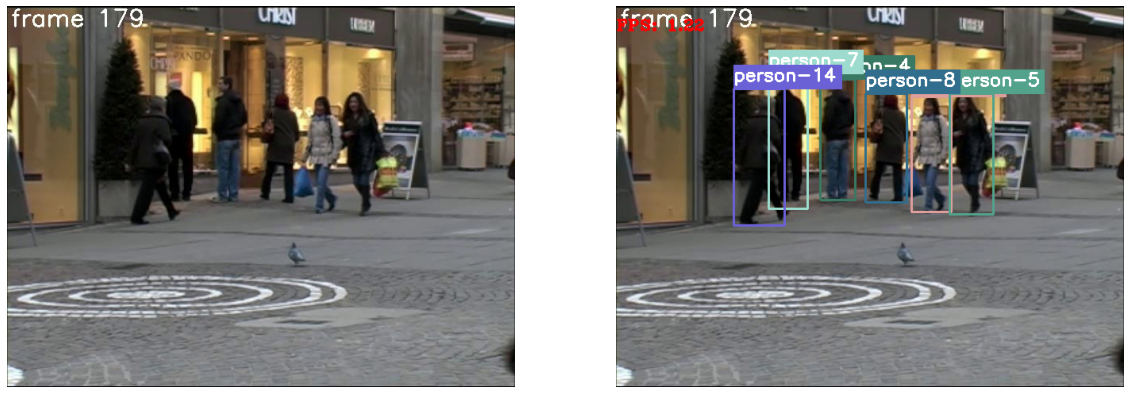

W0921 17:13:11.813798 140443666782016 deepsort.py:88] Empty Frame
W0921 17:13:11.917153 140443666782016 deepsort.py:88] Empty Frame
W0921 17:13:12.022072 140443666782016 deepsort.py:88] Empty Frame


In [4]:
if __name__ == '__main__':
    try:
        app.run(main,argv=_arg)
    except SystemExit:
        pass

## Opciones en linea de comandos 

```
deepsort.py:
  --video: Directorio del video o camara
    (default:videos_test/video_1.avi)
  --output: Directorio de salida para el video 
    (default: './output/tracks.avi')
  --nube: Cuando se correo sobre la nube y se quiere ver el video de salida en tiempo real
    (default: False)
  --showvideo: Si quiere ver el video, solo en maquina local
    (default: False)
  --outputtrack: Directorio de salida para txt con el historial de tracks 
    (default:output/tracks.txt)
```

## Medición de Rendimiento  

Las métricas usadas para medir el rendimiento del sistema son las mismas usadas en la competencia [MOTChallenge](https://motchallenge.net/). Estas métricas están implementadas en la librería [py-motmetrics](https://github.com/cheind/py-motmetrics)

### Mirada rápida a las metricas 

**Entre más alto mejor**, *Entre más bajo mejor*

Name|Name in py-motmetrics|Description
:---|:---|:---
**IDF1**|idf1|ID measures: global min-cost F1 score.
**IDP**|idp|ID measures: global min-cost precision.
**IDR**|idr|ID measures: global min-cost recall.
**Rcll**|recall|Ratio of correct detections to total number of ground truth boxes.
**Prcn**|precision|Ratio of TP / (TP+FP).
GT|num_unique_objects|Total number of unique object ids encountered.
MT|mostly_tracked|Number of objects tracked for at least 80 percent of lifespan.
PT|partially_tracked|Number of objects tracked between 20 and 80 percent of lifespan.
ML|mostly_lost|Number of objects tracked less than 20 percent of lifespan.
*FP*|num_false_positives|Total number of false positives (false-alarms).
*FN*|num_misses|Total number of misses.
*IDs*|num_switches|Total number of track switches.
*FM*|num_fragmentations|The total number of times a trajectory is fragmented (i.e. interrupted during tracking).
**MOTA**|mota|Multiple object tracker accuracy.
*MOTP*|motp|Multiple object tracker precision.

### Definición de Métricas 

#### Precisión de identificación IDp, recall de identifiación IDr y su correspondiente f1-score 

Estas medidas se usan para evaluar sistemas de seguimiento de objetos donde es crucial preservar el identificador de cada track.
Estas nos dicen que también los identificadores calculados se ajustan a los objetos que se estan intentando seguir, sin tener en cuenta donde o porque ocurren errores. Además estas medidas se preocupan por medir no por cuan a menudo se equivoca el sistema sino por cuanto tiempo el sistema identifica correctamente cada objeto seguido.

$IDTP: \text{True Positive ID}$

$IDFN: \text{False Negativo ID}$

$IDFP: \text{False Positivo ID}$


$$IDP = \frac{IDTP}{IDTP+IDFP}$$

$$IDR = \frac{IDTP}{IDTP+IDFN}$$

$$IDF1 = \frac{2\cdot IDTP}{2\cdot IDTP + IDFP + IDFN}$$

#### MOTA y MOPT

#### Multiple Object Tracking Accuracy 
$$\text{MOTA} = 1 - \frac{\sum_t(m_t + fp_t + mme_t)}{\sum_t{g_t}}$$

Donde $mt$,$fp_t$ y $mme_t$ son el número de objetos seguidos perdidos, falsos positivos y los cambios de identificación erroneos respectivamente, y $g_t$ es el número de objectos a seguir. 


#### Multiple Object Tracking Precision 
$$\text{MOTP} = \frac{\sum_{i,t} d_t^i}{\sum_t{c}_t}$$

Donde $d_t^i$ es la distancia euclidea entre el objeto a seguir y la identificación que le asigno el sistema y $c_t$ es el número de pares, formados por los objetos a seguir y la identidicación que le correspondio a cada uno.

![Image](./images/mot.png)
<center>Imagen 6</center>
<center>Métricas MOTA y MOPT</center>

### Resultados medida de rendimiento  

La prueba de rendimiento del sistema se evaluo sobre videos de entrenamiento de la base de datos [2D MOT 2015](https://motchallenge.net/data/2D_MOT_2015/). La idea de los videos utilizados era usar aquellos donde se presentaran situaciones paracedas al ambiente donde se quiere el sistema, camara estacionaria y personas relativamente cerca.
Para medir el rendimiento del sistema se necesitan dos archivos, el primero son las anotación o labels del video procesado y el otro archivo son los resultados obtenidos sobre el video del sistema de seguimiento. La forma en que se entregan los resultados es de la siguiente forma 

Número de la frame,ID , Coordenada x de la esquina superior izquiera , Coordenada y de la esquina superior izquiera, ancho, alto

**Ejemplo**

1,1,88,99,61.08,218.56

1,2,181,95,75.808,227.01

1,3,184,96,35.446,154.5

2,1,84,99,61.08,218.56

2,2,184,95,75.63,226.62


In [18]:
!python performance.py --annotations "./videos_test/gt_*.txt" --outputDet "./output/tracks_*.txt"

I0928 19:12:11.115155 140043499505472 utils.py:141] NumExpr defaulting to 8 threads.
Archivos:  ./videos_test/gt_ETH_Sunnyday.txt ./output/tracks_ETH_Sunnyday..txt
           IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML  FP FN IDs  FM  MOTA  MOTP
Resultado 61.4% 53.2% 72.4% 95.5% 70.2% 30 27  2  1 772 86   9  18 54.4% 0.200
Archivos:  ./videos_test/gt_KITTI_17.txt ./output/tracks_KITTI_17.txt
           IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML  FP  FN IDs  FM  MOTA  MOTP
Resultado 56.8% 70.1% 47.7% 54.9% 80.6%  9  0  9  0 103 353  12  31 40.2% 0.277
Archivos:  ./videos_test/gt_PETS09_S2L1.txt ./output/tracks_PETS09_S2L1.txt
           IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML  FP  FN IDs  FM  MOTA  MOTP
Resultado 69.1% 69.4% 68.8% 91.4% 92.1% 19 16  3  0 364 399  28  84 83.0% 0.257
Archivos:  ./videos_test/gt_TUD_Campus.txt ./output/tracks_TUD_Campus.txt
           IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML  FP FN IDs  FM  MOTA  MOTP
Resultado 58.8% 56.2% 61.6% 75.5% 69.0%  8  3  5  0 122 88 

Resultados de otros sistemas de seguimiento [aquí](https://motchallenge.net/results/2D_MOT_2015/). Tenga en cuetas que estos resultados muestran el rendimiento de otros sistemas sobre un conjunto de datos más grande, pero con retos similares a los videos probados en el presente informe. 

## Conclusiones 

* La implementación de sistemas de seguimiento de objetivos basados en aprendizaje profundo ahora se pueden desarrollar más fácilmente gracias a la capacidad de cómputo disponible, sistemas locales capaces o servicios en la nube, y a la eficiencia de los algoritmos.

* El uso de servicios en la nube ayuda considerablemente a la implementación y la fase de desarrollo de los algoritmos cuando localmente no se cuenta con las herramientas suficientes o se quiere procesar más rápidamente. 

* Para mejorar el desempeño del sistema se hace necesario realizar cambios según sea el ambiente donde se piensa implementar. Cada ambiente tiene sus propios parámetros  que influyen sobre el rendimiento del sistema. Específicamente estos parámetros influyen sobre las partes del sistema que usa aprendizaje profundo para su funcionamiento, como el detector y el encoder. Se recomienda entonces realizar cambios como lo pueden ser el reentrena miento o cambio del detector, o cambiar la CNN encargada de la creación del descriptor de la imagen, según sea la implementación.

## Referencias

* [SIMPLE ONLINE AND REALTIME TRACKING WITH A DEEP ASSOCIATION METRIC](https://arxiv.org/pdf/1703.07402.pdf)

* [Deep Cosine Metric Learning for Person Re-Identification](https://arxiv.org/pdf/1812.00442.pdf)

* [SIMPLE ONLINE AND REALTIME TRACKING](https://arxiv.org/pdf/1602.00763.pdf)

* [Computer Vision for tracking](https://towardsdatascience.com/computer-vision-for-tracking-8220759eee85)

* [Object tracking deepsort](https://nanonets.com/blog/object-tracking-deepsort/)

* [Recent Advances in Deep Learning for Object Detection](https://www.dlology.com/blog/recent-advances-in-deep-learning-for-object-detection/)

* [Evaluating Multiple Object Tracking Performance:The CLEAR MOT Metrics](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.367.6279&rep=rep1&type=pdf)

* [Performance Measures and a Data Set forMulti-Target, Multi-Camera Tracking](https://arxiv.org/pdf/1609.01775.pdf)

* [Object Tracking using YOLOv3, Deep Sort and Tensorflow](https://github.com/theAIGuysCode/yolov3_deepsort)

* [YoloV3 Implemented in TensorFlow 2.0](https://github.com/zzh8829/yolov3-tf2)

* [Py-motmetrics](https://github.com/cheind/py-motmetrics#References)